In [133]:
%reload_ext autoreload
%autoreload

In [134]:
import pandas as pd
import geopandas as gpd
import shapely
import nomad.io.base as loader
import numpy as np
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import nomad.stop_detection.utils as utils
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.stop_detection.grid_based as GRID_BASED # for oracle visits
import nomad.visit_attribution as visits
import nomad.filters as filters
from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, compute_precision_recall_f1

In [135]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
poi_table = gpd.read_file('../garden_city.gpkg')

diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", traj_cols=traj_cols,
                       parse_dates=True)
diaries_df = diaries_df.rename({'location':'building_id'}, axis=1) # annoying

sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", traj_cols=traj_cols,
                      parse_dates=True)

## Analyze completeness

In [136]:
completeness_df = filters.q_stats(sparse_df, traj_cols=traj_cols)

In [137]:
completeness_df

,uid,q_stat
0,admiring_pike,0.407791
1,admiring_swirles,0.230373
2,adoring_almeida,0.335281
3,adoring_chandrasekhar,0.558307
4,adoring_einstein,0.515035
...,...,...
195,youthful_meninsky,0.504503
196,youthful_thompson,0.270936
197,youthful_wilson,0.549308
198,zealous_cray,0.159417


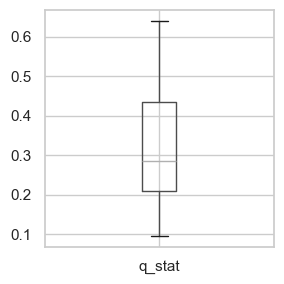

In [138]:
plt.figure(figsize=(3,3))
completeness_df.boxplot(column="q_stat")
plt.grid(True)
plt.tight_layout()

plt.show()

## Example for one user

In [139]:
# Select data from 1 user
user1 = diaries_df.uid.unique()[0]

sparse1 = sparse_df.loc[sparse_df['uid'] == user1]
diary1 = diaries_df.loc[diaries_df.uid == user1]

In [142]:
%%time
DUR_MIN=5
DT_MAX=90
DELTA_ROAM=30
# to summarize stops after groupby passing through individual locations
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols = ['building_id']) # < function(grouped_data)

# If we want to use 'majority' to attribute visits, then we need stop labels on each ping
labels_hdbscan = HDBSCAN.hdbscan_labels(traj=sparse1,
                                            time_thresh=100,
                                            min_pts=2,
                                            min_cluster_size=3,
                                            traj_cols=traj_cols)
labels_hdbscan.name = 'cluster'
# join with the original data
sparse_with_cluster = sparse1.join(labels_hdbscan)

# has same index as data
pred_hdbscan = visits.point_in_polygon(data=sparse_with_cluster,
                                        poi_table=poi_table,
                                        method='majority',
                                        data_crs='EPSG:3857',
                                        max_distance=10,
                                        cluster_label='cluster',
                                        location_id='building_id',
                                        x='x',
                                        y='y')
# join the building id
pred = sparse_with_cluster.join(pred_hdbscan)

stop_table_hdbscan = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
stop_table_hdbscan.head()

CPU times: user 188 ms, sys: 4.7 ms, total: 192 ms
Wall time: 211 ms


,cluster,x,y,start_timestamp,duration,building_id
0,1,-4.265619e+06,4.393128e+06,1704121740,137,w-x6-y9
1,2,-4.265575e+06,4.393197e+06,1704154440,63,h-x8-y13
2,3,-4.265570e+06,4.393182e+06,1704172860,11,h-x8-y13
3,4,-4.265439e+06,4.393106e+06,1704271980,32,w-x18-y8
4,5,-4.265617e+06,4.393127e+06,1704363840,233,w-x6-y9


In [144]:
truth

,uid,timestamp,longitude,latitude,x,y,date,datetime,duration,building_id,tz_offset
43594,mystifying_wozniak,1704099660,NaN,NaN,NaN,NaN,2024-01-01,2024-01-01 08:01:00,4,None,-3600
43595,mystifying_wozniak,1704099900,-38.316799,36.669839,-4265406.5,4393186.0,2024-01-01,2024-01-01 08:05:00,26,r-x18-y13,-3600
43596,mystifying_wozniak,1704101460,NaN,NaN,NaN,NaN,2024-01-01,2024-01-01 08:31:00,5,None,-3600
43597,mystifying_wozniak,1704101760,-38.317338,36.668866,-4265466.5,4393051.0,2024-01-01,2024-01-01 08:36:00,205,w-x15-y3,-3600
43598,mystifying_wozniak,1704114060,NaN,NaN,NaN,NaN,2024-01-01,2024-01-01 12:01:00,5,None,-3600
...,...,...,...,...,...,...,...,...,...,...,...
43823,mystifying_wozniak,1705259220,-38.317472,36.669677,-4265481.5,4393163.5,2024-01-14,2024-01-14 18:07:00,99,h-x13-y12,-3600
43824,mystifying_wozniak,1705265160,NaN,NaN,NaN,NaN,2024-01-14,2024-01-14 19:46:00,4,None,-3600
43825,mystifying_wozniak,1705265400,-38.316799,36.669839,-4265406.5,4393186.0,2024-01-14,2024-01-14 19:50:00,11,r-x18-y13,-3600
43826,mystifying_wozniak,1705266060,NaN,NaN,NaN,NaN,2024-01-14,2024-01-14 20:01:00,4,None,-3600


In [152]:
overlapping_visits(left=stop_table_hdbscan,
                   right=diary1,
                   location_id='building_id',
                   match_location=True)

,start_timestamp_left,building_id,end_timestamp_left,start_timestamp_right,end_timestamp_right,duration
0,1704121740,w-x6-y9,1704129960,1704121560,1704135660,137
1,1704154440,h-x8-y13,1704158220,1704135840,1704186060,63
2,1704172860,h-x8-y13,1704173520,1704135840,1704186060,11
3,1704271980,w-x18-y8,1704273900,1704272700,1704286860,20
4,1704363840,w-x6-y9,1704377820,1704362700,1704373260,157
5,1704557100,w-x18-y13,1704559680,1704553680,1704564960,43
6,1704662880,h-x12-y13,1704664320,1704655080,1704675660,24
7,1704736500,w-x6-y9,1704738120,1704726420,1704740460,27
8,1704800160,w-x6-y9,1704803520,1704794640,1704805260,56
9,1704901980,w-x6-y9,1704906480,1704899220,1704913260,75


In [87]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
stop_detection_algos = ['oracle', 'lachesis', 'ta-dbscan', 'hdbscan']

metrics_df = pd.DataFrame()
TIME_THRESH=240
DIST_THRESH=25
MIN_PTS=2

DUR_MIN=5
DT_MAX=240
DELTA_ROAM=35

for user in tqdm(diaries_df.uid.unique()[:200], desc='Processing users'):
    for algo in stop_detection_algos:
        sparse = sparse_df[sparse_df['uid'] == user].copy()
        truth = diaries_df.loc[diaries_df['uid'] == user].copy()
        
        if algo == 'oracle':
            # oracle says correct poi for each ping
            location = visits.oracle_map(
                sparse,
                truth,
                timestamp='timestamp',
                location_id='building_id')
            # find cluster labels with naive grid-based continuity
            labels = GRID_BASED.grid_based_labels(
                data=sparse.join(location),
                time_thresh=TIME_THRESH,
                min_pts=0, #we allow stops of duration 0, patched later
                location_id='building_id',
                traj_cols=traj_cols)
        
        elif algo == 'lachesis':
            labels = LACHESIS._lachesis_labels(
                traj=sparse,
                dur_min=DUR_MIN,
                dt_max=DT_MAX,
                delta_roam=DELTA_ROAM,
                traj_cols=traj_cols)
            
            labels.name = 'cluster'           
            sparse_with_cluster = sparse.join(labels)
            
        elif algo == 'ta-dbscan':
            labels = TADBSCAN._temporal_dbscan_labels(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)
            
        elif algo == 'hdbscan':
            labels = HDBSCAN.hdbscan_labels(
                traj=sparse,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=3,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)
        else:
            print(f"Algorithm {algo} not in the list!")

        # ----------- COMPUTE STOPS FROM LABELS -----------------------
        if algo != 'oracle': 
            pred = visits.point_in_polygon(data=sparse_with_cluster,
                                            poi_table=poi_table,
                                            method='majority',
                                            data_crs='EPSG:3857',
                                            max_distance=15,
                                            cluster_label='cluster',
                                            location_id='building_id',
                                            x='x',
                                            y='y')
        
            pred = sparse_with_cluster.join(pred)
            stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
            try:
                utils.invalid_stops(stops)
            except:
                labels = GRID_BASED.grid_based_labels(
                                data=pred.drop('cluster', axis=1),
                                time_thresh=TIME_THRESH,
                                min_pts=0, #we allow stops of duration 0, patched later
                                location_id='building_id',
                                traj_cols=traj_cols)
                
                pred['cluster'] = labels
                stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
            
        else: #location exists by oracle, we join everything
            pred = sparse.join(location).join(labels)
            stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
            # we add a 5min duration to oracle stops with just one ping
            stops = utils.pad_short_stops(stops, pad=5, dur_min=0, start_timestamp = 'start_timestamp') 

        
        # ----------- COMPUTE METRICS OF INTEREST -----------------------
        # Step 1: Compute overlaps
        #RAISE ERROR IF OVERLAPS
        overlaps = overlapping_visits(left=stops,
                                      right=truth,
                                      location_id='building_id',
                                      match_location=False)

        # Step 2: Compute visitation errors (missed, merged, split)
        errors = compute_visitation_errors(overlaps=overlaps,
                                           true_visits=truth,
                                           location_id='building_id')

        # Step 3: Compute precision, recall, and F1
        prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                           pred_visits=stops,
                                           true_visits=truth,
                                           location_id='building_id')

        all_metrics = {**errors, **prf1, 'user': user, 'algorithm': algo}
        metrics_df = pd.concat([metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

Processing users: 100%|██████████| 200/200 [07:06<00:00,  2.13s/it]


In [130]:
metrics_df.to_csv("metrics_df.csv", index=False)

In [58]:
# # Postprocessing based on location!
# labels = GRID_BASED.grid_based_labels(
#                 data=pred.drop('cluster', axis=1),
#                 time_thresh=TIME_THRESH,
#                 min_pts=0, #we allow stops of duration 0, patched later
#                 location_id='building_id',
#                 traj_cols=traj_cols)

# pred['cluster'] = labels
# pred = pred.loc[pred.cluster!=-1]

# merged_data_hdbscan = pred.loc[(pred.timestamp>= 1704114480)&(pred.timestamp <= 1704116340)]

In [ ]:
# %matplotlib inline
# # Merging sample data with labels
# fig, ax = plt.subplots(figsize=(6, 6))
# plt.box(on=True)
# # Plotting Garden City Map
# poi_table.plot(ax=ax, color='green', alpha=0.3)
# # Getting colors for clusters
# unique_clusters = sorted(merged_data_hdbscan['cluster'].unique())
# cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
# if -1 in cluster_mapping:
#     del cluster_mapping[-1]
# mapped_clusters = merged_data_hdbscan['cluster'].map(cluster_mapping).to_numpy()
# cmap_base = plt.get_cmap('Dark2', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
# # colors = [‘gray’] + list(cmap_base.colors)
# colors = list(cmap_base.colors)
# extended_cmap = mcolors.ListedColormap(colors)
# # Plotting Pings
# ax.scatter(merged_data_hdbscan['x'],
#            merged_data_hdbscan['y'],
#            c=mapped_clusters,
#            cmap=extended_cmap,
#            s=6,
#            alpha=1,
#            zorder=2)
# ax.set_yticklabels([])
# ax.set_xticklabels([])
# # ax.set_title(“HDBSCAN Stops for Sample User”)
# ax.set_xticks([])
# ax.set_yticks([])
# # ax.set_xlim(12, 22)
# # ax.set_ylim(7, 14)
# plt.tight_layout()
# # plt.savefig(‘gc_empty.png’)
# plt.show()

In [128]:
metrics_df = pd.read_csv('metrics_df.csv')

In [129]:
metrics_df

,Unnamed: 0,missed_fraction,merged_fraction,split_fraction,precision,recall,f1,user,algorithm,user_idx
0,0,0.873984,0.000000,0.008130,1.000000,0.096230,0.175566,gracious_babbage,oracle,75
1,1,0.898374,0.008130,0.016260,0.997956,0.096875,0.176606,gracious_babbage,lachesis,75
2,2,0.902439,0.008130,0.020325,0.998047,0.101389,0.184078,gracious_babbage,ta-dbscan,75
3,3,0.873984,0.093496,0.004065,0.965103,0.123462,0.218919,gracious_babbage,hdbscan,75
4,4,0.686916,0.000000,0.009346,0.999258,0.401042,0.572369,happy_ritchie,oracle,80
...,...,...,...,...,...,...,...,...,...,...
795,795,0.878641,0.101942,0.000000,0.959308,0.101736,0.183963,kind_wescoff,hdbscan,105
796,796,0.726496,0.000000,0.012821,0.999496,0.294891,0.455416,mystifying_wozniak,oracle,119
797,797,0.773504,0.017094,0.029915,0.998510,0.265873,0.419931,mystifying_wozniak,lachesis,119
798,798,0.777778,0.034188,0.029915,0.998064,0.281349,0.438958,mystifying_wozniak,ta-dbscan,119


In [89]:
# metrics_df.groupby(['algorithm'])[['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']].mean()

bootstrapping=True
if bootstrapping:
    output = []
    agg_keys = ['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']
    agg_dict = {key:'median' for key in agg_keys}
    for _ in range(100):
        output += [metrics_df.sample(len(metrics_df), replace=True).groupby('algorithm', as_index=False).agg(agg_dict)]
    metrics_bootstrap_df = pd.concat(output)

In [90]:
metrics_bootstrap_df

,algorithm,missed_fraction,merged_fraction,split_fraction,precision,recall,f1
0,hdbscan,0.782924,0.153454,0.004878,0.976839,0.240947,0.386094
1,lachesis,0.847836,0.009709,0.026457,0.998055,0.156126,0.269888
2,oracle,0.806931,0.000000,0.014019,0.999476,0.177083,0.300860
3,ta-dbscan,0.858974,0.021930,0.022727,0.997131,0.178671,0.303058
0,hdbscan,0.794355,0.154324,0.008333,0.975484,0.259648,0.410189
...,...,...,...,...,...,...,...
3,ta-dbscan,0.852679,0.023810,0.027027,0.997453,0.186756,0.314549
0,hdbscan,0.794355,0.151786,0.005051,0.975223,0.243006,0.388840
1,lachesis,0.819224,0.012931,0.026316,0.997849,0.183953,0.310491
2,oracle,0.799573,0.000000,0.016001,0.999373,0.192411,0.322712


In [ ]:
# TO DO: plot by building area, by dwell time

In [ ]:
# TO DO: expand algorithm list. lachesis_coarse, lachesis_fine, ta_dbscan_coarse, ta_dbscan_fine, oracle_coarse, oracle_fine

## Exploration of building size, building type, dwell

In [ ]:
import nomad.city_gen as cg
city = cg.load('../garden-city.pkl')

def classify_building_size_from_id(building_id):
    building = city.buildings.get(building_id)
    n_blocks = len(building.blocks)
    if n_blocks == 1:
        return 'small'
    elif 2 <= n_blocks <= 3:
        return 'medium'
    else:
        return 'big'

def classify_building_type_from_id(building_id):
    building = city.buildings.get(building_id)
    return building.building_type


def classify_dwell(duration):
    if duration <= 5:
        return 'low'
    elif 6 <= duration <= 120:
        return 'mid'
    else:
        return 'high'

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.box(on=True)

# Plotting Garden City Map

city.plot_city(ax, doors=True, address=True)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
city.buildings['r-x5-y0'].blocks

In [ ]:
city.buildings

## Usage of oracle_map and location_based stop detection

In [ ]:
# Select data from 1 user
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols = ['building_id'])
user = diaries_df.uid.unique()[1]

sparse = sparse_df.loc[sparse_df['uid'] == user]
truth = diaries_df.loc[diaries_df.uid == user]

In [ ]:
user

In [ ]:
location = visits.oracle_map(sparse, truth, timestamp='timestamp', location_id='building_id')

In [ ]:
labels = GRID_BASED.grid_based_labels(data=sparse.join(location),
                             time_thresh=240,
                             min_pts=0,
                             datetime='local_timestamp',
                             location_id='building_id')
pred = sparse.join(location).join(labels)

In [ ]:
stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
stops = utils.pad_short_stops(stops, pad=5, start_timestamp = 'start_timestamp') # we add a little duration to oracle stops with just one ping

In [ ]:
# Step 1: Compute overlaps
overlaps = overlapping_visits(left=stops,
                              right=truth,
                              location_id='building_id',
                              match_location=False)

# Step 2: Compute visitation errors (missed, merged, split)
errors = compute_visitation_errors(overlaps=overlaps,
                                   true_visits=truth,
                                   location_id='building_id')

# Step 3: Compute precision, recall, and F1
prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                   pred_visits=stops,
                                   true_visits=truth,
                                   location_id='building_id')

In [ ]:
print(errors)
print(prf1)